<a href="https://colab.research.google.com/github/Mafatihul/HateComment_Classification/blob/train/HateComment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PySastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 4.5 MB/s eta 0:00:00


In [3]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
nltk.download('stopwords')
stopwords.words('indonesian')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load Dataset

In [10]:
# Loading preprocessed train set dan test set

train_set = pd.read_csv('/content/drive/MyDrive/Skripsi/Dataset/train_preprocessed(02122024).csv', encoding='latin-1') # 2064 data
test_set = pd.read_csv('/content/drive/MyDrive/Skripsi/Dataset/test_preprocessed(03122024).csv', encoding='latin-1') # 542 data

train_set.head()

,Texts,Is_HateComments,case_folded,normalized,stopword_removed,stemmed,tokenized
0,perlakuin karyawan selayaknya memanusiakan man...,0,perlakuin karyawan selayaknya memanusiakan man...,perlakukan karyawan selayaknya memanusiakan ma...,perlakukan karyawan selayaknya memanusiakan ma...,laku karyawan layak manusia manusia ya kakak,"['laku', 'karyawan', 'layak', 'manusia', 'manu..."
1,kaesang pisang lo gimana in bos?,1,kaesang pisang lo gimana in bos,kaesang pisang kamu bagaimana in bos,kaesang pisang in bos,kaesang pisang in bos,"['kaesang', 'pisang', 'in', 'bos']"
2,coba makanan ci mehong,0,coba makanan ci mehong,coba makanan ci mahal,coba makanan ci mahal,coba makan ci mahal,"['coba', 'makan', 'ci', 'mahal']"
3,kak tasyi itu positive vibes banget.,0,kak tasyi itu positive vibes banget,kak tasyi itu positif vibes banget,kak tasyi positif vibes banget,kak tasyi positif vibes banget,"['kak', 'tasyi', 'positif', 'vibes', 'banget']"
4,next cobain semua ice cream aice dari yang mur...,0,next cobain semua ice cream aice dari yang mur...,next coba semua ice cream aice dari yang murah...,next coba ice cream aice murah mahal kak,next coba ice cream aice murah mahal kak,"['next', 'coba', 'ice', 'cream', 'aice', 'mura..."


In [22]:
# Mengambil data yang sudah distemming dan label data untuk train_df dan test_df

train_df = train_set[['stemmed', 'Is_HateComments']]
test_df = test_set[['stemmed', 'Is_HateComments']]

train_df.head()

,stemmed,Is_HateComments
0,laku karyawan layak manusia manusia ya kakak,0
1,kaesang pisang in bos,1
2,coba makan ci mahal,0
3,kak tasyi positif vibes banget,0
4,next coba ice cream aice murah mahal kak,0


In [23]:
# prompt: counting nan in train_df['stemmed'] and delete the row

# Count NaN values in 'stemmed' column
nan_count = train_df['stemmed'].isnull().sum()
print(f"Number of NaN values in 'stemmed' column: {nan_count}")

# Remove rows with NaN values in 'stemmed' column
train_df = train_df.dropna(subset=['stemmed'])

# Verify the change
print(f"Shape of train_df after removing NaN rows: {train_df.shape}")

Number of NaN values in 'stemmed' column: 1
Shape of train_df after removing NaN rows: (2163, 2)


In [24]:
train_df

,stemmed,Is_HateComments
0,laku karyawan layak manusia manusia ya kakak,0
1,kaesang pisang in bos,1
2,coba makan ci mahal,0
3,kak tasyi positif vibes banget,0
4,next coba ice cream aice murah mahal kak,0
...,...,...
2159,maju editor nya kayak kemarin battle basreng,0
2160,orang makan getok,1
2161,kak coba salad thailand,0
2162,review cik mahal,0


# N-Gram Feature Extraction

In [14]:
# function to flatten one list
def flat_list(unflat_list):
    flatted = [item for sublist in unflat_list for item in sublist]
    return flatted

In [26]:
def to_list(df, attribute):
    # Select the normalised transcript column
    df_transcription = df[[attribute]]
    # To convert the attribute into list format, but it has inner list. So it cannot put into the CountVectoriser
    unflat_list_transcription = df_transcription.values.tolist()
    # Let's use back the function defined above, "flat_list", to flatten the list
    flat_list_transcription = flat_list(unflat_list_transcription)
    return flat_list_transcription
flat_list_transcription = to_list(train_df, 'stemmed')

In [42]:
# Fitur ngram yang akan digunakan
# ngram_features ={'unigram':(1,1),'bigram':(2,2), 'trigram':(3,3)}
ngram_features ={'unigram':(1,1),'bigram':(2,2), 'trigram':(3,3)}
feature_name=[]
temp=[]

for key, values in ngram_features.items():
    temp.append(key)
    feature_name.append(key)
temp

['unigram', 'bigram', 'trigram']

In [43]:
# Fungsi untuk generate fitur ngram dari teks dalam dataset
def generate_ngram_features(text_data):
    temp=[]
    # Melakukan perulangan untuk mengekstrak n-gram
    for key, values in ngram_features.items():
        vectorizer = TfidfVectorizer(ngram_range=values)

        X = vectorizer.fit_transform(text_data)
        # Menyimpan fitur yang sudah diekstrak
        temp.append(X)
    return temp
temp = generate_ngram_features(flat_list_transcription)

In [44]:
#fungsi untuk menampilkan vektor fitur
def ngram_table(temp, feature_name):
  for i in range(len(temp)):
    features = temp[i]
    vectorizer = TfidfVectorizer(ngram_range=ngram_features[feature_name[i]])
    vectorizer.fit(flat_list_transcription)
    df_ngram = pd.DataFrame(features.toarray(), columns = vectorizer.get_feature_names_out())
    # Menampilkan nama fitur
    print(f"N-gram: {feature_name[i]}")
    display(df_ngram)
    print("\n")
  return df_ngram

# Menerapkan fungsi untuk mengekstrak n-gram dari dataset
feature_table = ngram_table(temp, feature_name)

N-gram: unigram


,abang,abu,ac,acara,aceh,ada,adab,adalh,adddeehhh,adek,...,ytbr,yuk,yuliandri,zahra,zaitun,zaki,zalim,zaman,zh,zumrotun
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




N-gram: bigram


,abang ganteng,abu hurairah,abu jahal,abu lahab,acara apa,acara tukang,ada klarifikasi,adab kamera,adab li,adab sebar,...,zalim parah,zalim saudara,zalim sih,zalim suami,zalim wkwk,zalim ya,zaman firaun,zaman jahiliyyah,zh buzzer,zumrotun potong
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




N-gram: trigram


,abang ganteng daeng,abu hurairah radiyallahu,abu jahal kembali,abu lahab abu,abu lahab dibandingin,acara apa makan,acara tukang cilok,ada klarifikasi ya,adab sebar publik,adab sesuai ajar,...,zalim parah pasang,zalim saudara eh,zalim sih jatuh,zalim sih spil,zalim suami tasyi,zaman firaun kasih,zaman jahiliyyah brsikap,zaman jahiliyyah kasihan,zh buzzer tasyi,zumrotun potong sih
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Menyimpan matriks fitur dalam file csv

feature_table.to_csv('/content/drive/MyDrive/Skripsi/Dataset/test_tri-gram.csv')

In [46]:
# Dataframe untuk menyimpan fitur yang sudah diekstrak
feature_dataframes = {'unigram':temp[0],
                      'bigram':temp[1],
                      'trigram':temp[2]}
feature_vector = [] ; feature_vector_shape = []
for key in feature_dataframes:
    feature_vector.append(key)
    feature_vector_shape.append(feature_dataframes[key].shape)

# Menampilkan vector shape dari setiap fitur n-gram
n_gram_df = pd.DataFrame({'Fitur N-Gram':feature_vector, 'Dimensi Data':feature_vector_shape})
n_gram_df

,Fitur N-Gram,Dimensi Data
0,unigram,"(2163, 3028)"
1,bigram,"(2163, 10664)"
2,trigram,"(2163, 11621)"


# Define Grid Search and Base model

In [53]:
from sklearn.model_selection import KFold, GridSearchCV

# Define KFold
kfold = KFold(n_splits=10)
# Define the grid of hyperparameters to search over
param_grid = {
    'C': [0.01, 0.05, 0.1, 1, 10, 100],
    'gamma': [0.1, 0.05, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Define the SVM model
svm_model = SVC()

gridSearch = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=kfold)

In [49]:
# Split test dataset menjadi test set (X dan y)
X_test = test_df['stemmed']
y_test = test_df['Is_HateComments']

In [50]:
# Import confusion matrix dan fungsi untuk menghitung skor yang diperlukan
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, log_loss

# Fungsi untuk menampilkan hasil pengujian menggunakan confussion matrix
def print_matrix(y_test, y_pred):
  # Calculate the confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Print the confusion matrix
  print("Confusion matrix:")
  print(cm)

  # Perhitungan skor akurasi
  accuracy = accuracy_score(y_test, y_pred)

  # Menghitung f1-score
  f1 = f1_score(y_test, y_pred)

  # Calculate the precision
  precision = precision_score(y_test, y_pred)

  # Calculate the recall
  recall = recall_score(y_test, y_pred)

  loss = log_loss(y_test, y_pred)

  # Print the metrics
  print("Accuracy:", accuracy)
  print("F1-score:", f1)
  print("Precision:", precision)
  print("Recall:", recall)
  print("Loss:", loss)

  # Plot the confusion matrix
  plt.figure(figsize=(4, 3))
  plt.imshow(cm, cmap="Blues")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.xticks([0, 1], ["Not Hate Speech", "Hate Speech"])
  plt.yticks([0, 1], ["Not Hate Speech", "Hate Speech"])
  plt.colorbar()
  plt.show()

# Uni-Gram

In [54]:
# Train set untuk training model dengan fitur uni-gram
X_train_unigram = feature_dataframes['unigram']
y_train_unigram = train_df['Is_HateComments']

In [55]:
# Training dan
gridSearch.fit(X_train_unigram, y_train_unigram)

# Get the best hyperparameters
unigram_bestParams = gridSearch.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(unigram_bestParams)

Best hyperparameters:
{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}


Confusion matrix:
[[213  56]
 [103 170]]
Accuracy: 0.7066420664206642
F1-score: 0.6813627254509018
Precision: 0.7522123893805309
Recall: 0.6227106227106227
Loss: 10.57369167688123


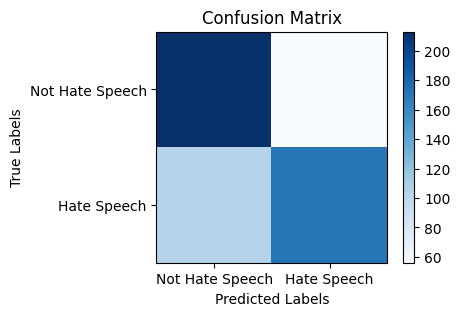

In [56]:
# Menyimpan model dengan best parameter
best_svm_unigram = SVC(**unigram_bestParams)

# Fit the model to the training data
best_svm_unigram.fit(X_train_unigram, y_train_unigram)

# Transform the test data using the same vectorizer used for training
X_test_unigram = TfidfVectorizer(ngram_range=(1,1)).fit(flat_list_transcription).transform(X_test)

# Predict the labels for the test data
y_pred_unigram = best_svm_unigram.predict(X_test_unigram)

# Menampilkan hasil pengujian
# print(classification_report(y_test, y_pred_unigram))
print_matrix(y_test, y_pred_unigram)

In [66]:
# Create a DataFrame to display predicted and true classes
results_df = pd.DataFrame({'Texts': X_test,'Predicted Class': y_pred_unigram, 'True Class': y_test})
results_df

,Texts,Predicted Class,True Class
0,cewek gas,0,1
1,unsubscribe jemaah yuk sih manusia manusia,1,1
2,orang parah laku manusia binatang kakak tasyi ...,0,1
3,kak tasyi tunggu konten ceramah nih biar adem ...,1,1
4,bawah sampah kantong plastik sampah,1,0
...,...,...,...
537,unsubcirbe tau,0,1
538,buzzer,0,1
539,kakak bikin minimarket indomaret,0,0
540,wkwk lucu banget,0,1


In [67]:
# prompt: menyimpan model

import joblib

# ... (your existing code)

# Save the trained unigram model
filename = '/content/drive/MyDrive/Skripsi/Dataset/best_svm_unigram_model.sav'
joblib.dump(best_svm_unigram, filename)

# ... (rest of your code)

['/content/drive/MyDrive/Skripsi/Dataset/best_svm_unigram_model.sav']

# Bi-Gram

In [57]:
# Train set untuk training model dengan fitur uni-gram
X_train_Bigram = feature_dataframes['bigram']
y_train_Bigram = train_df['Is_HateComments']

In [59]:
# Training dan
gridSearch.fit(X_train_Bigram, y_train_Bigram)

# Get the best hyperparameters
Bigram_bestParams = gridSearch.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(Bigram_bestParams)

Best hyperparameters:
{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


Confusion matrix:
[[155 114]
 [ 68 205]]
Accuracy: 0.6642066420664207
F1-score: 0.6925675675675675
Precision: 0.6426332288401254
Recall: 0.7509157509157509
Loss: 12.103219403725687


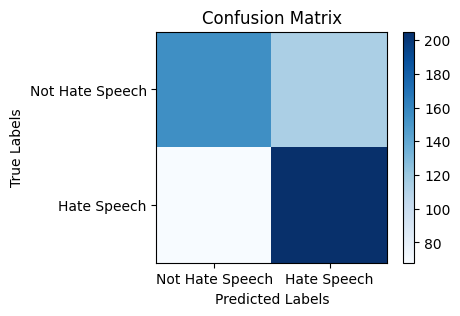

In [60]:
# Redefine svm model with best hyperparameter
best_svm_Bigram = SVC(**Bigram_bestParams)

# Fit the model to the training data
best_svm_Bigram.fit(X_train_Bigram, y_train_Bigram)

# Transform the test data using the same vectorizer used for training
X_test_Bigram = TfidfVectorizer(ngram_range=(2,2)).fit(flat_list_transcription).transform(X_test)

# Predict the labels for the test data
y_pred_Bigram = best_svm_Bigram.predict(X_test_Bigram)

print_matrix(y_test, y_pred_Bigram)

# Trigram

In [61]:
# Train set untuk training model dengan fitur tri-gram
X_train_Trigram = feature_dataframes['trigram']
y_train_Trigram = train_df['Is_HateComments']

In [62]:
# Tunning hyperprameter menggunakan gridsearch
gridSearch.fit(X_train_Trigram, y_train_Trigram)

# Get the best hyperparameters
Trigram_bestParams = gridSearch.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(Trigram_bestParams)

Best hyperparameters:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


Confusion matrix:
[[ 76 193]
 [ 26 247]]
Accuracy: 0.5959409594095941
F1-score: 0.6928471248246845
Precision: 0.5613636363636364
Recall: 0.9047619047619048
Loss: 14.563764007779808


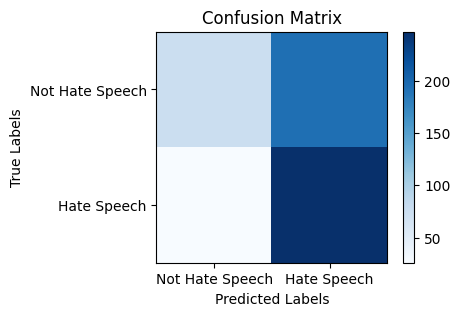

In [63]:
# Redefine svm model with best hyperparameter
best_svm_Trigram = SVC(**Trigram_bestParams)

# Fit the model to the training data
best_svm_Trigram.fit(X_train_Trigram, y_train_Trigram)

# Transform the test data using the same vectorizer used for training
X_test_Trigram = TfidfVectorizer(ngram_range=(3,3)).fit(flat_list_transcription).transform(X_test)

# Predict the labels for the test data
y_pred_Trigram = best_svm_Trigram.predict(X_test_Trigram)

print_matrix(y_test, y_pred_Trigram)